# Table of Contents
 <p><div class="lev1 toc-item"><a href="#OSMI-Health-Survey-2016:-Model-Selection" data-toc-modified-id="OSMI-Health-Survey-2016:-Model-Selection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>OSMI Health Survey 2016: Model Selection</a></div><div class="lev1 toc-item"><a href="#Post-Processing-Summary" data-toc-modified-id="Post-Processing-Summary-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Post-Processing Summary</a></div><div class="lev1 toc-item"><a href="#Post-Processing-EDA" data-toc-modified-id="Post-Processing-EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Post-Processing EDA</a></div><div class="lev3 toc-item"><a href="#Search-for-interaction-effects" data-toc-modified-id="Search-for-interaction-effects-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Search for interaction effects</a></div><div class="lev1 toc-item"><a href="#Initial-Modeling" data-toc-modified-id="Initial-Modeling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Initial Modeling</a></div><div class="lev2 toc-item"><a href="#Decision-Tree" data-toc-modified-id="Decision-Tree-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Decision Tree</a></div><div class="lev2 toc-item"><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Logistic Regression</a></div><div class="lev3 toc-item"><a href="#Diagnostics" data-toc-modified-id="Diagnostics-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Diagnostics</a></div><div class="lev1 toc-item"><a href="#Model-Selection" data-toc-modified-id="Model-Selection-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Selection</a></div>

# OSMI Health Survey 2016: Model Selection

_By [Michael Rosenberg](mailto:mmrosenb@andrew.cmu.edu)._

_**Description**: Contains my model selection related to the [OSMI Mental Health In Tech Survey 2016](https://osmihelp.org/research/). This notebook is written in `R`._

In [2]:
#imports
library(tree)
#constants
options(warn=-1) #turn off warnings
sigLev = 3

In [3]:
#read in the data
mainFrame = read.csv("../data/processed/procDataset.csv")

In [4]:
mainFrame$diagnosedWithMHD = ifelse(mainFrame$diagnosedWithMHD == "Yes",1,0)

# Post-Processing Summary

After processing the dataset using [../code/cleanDataset.py](../code/cleanDataset.py), we are left with a certain set of variables:

* ```diagnosedWithMHD```: This is our main target variable. This is the variable that indicates whether an individual has been diagnosed with a mental health disorder by a medical professional. We give a $1$ for diagnosis, and a $0$ for a non-diagnosis.

* ```workPosString```: This is a string that contains all the job descriptions of each respondent. Each of these job descriptions are separated using the "or" character ("|").

* ```roleType```: A simplification of job descriptions to technical, non-technical, or both types of roles. This encoding is discussed partially in the [exploratory analysis](exploratoryDataAnalysis.ipynb).

* ```companySize```: A representation of the size of the company. Individuals who state that they are self-employed are indicated as "Self-employed" in this variable.

* ```age```: The age of the respondent.

* ```workCountry```: The country where a respondent works.

* ```workState```: The state where a respondent works if said respondent claims to work in the United States of America.

* ```gender```: The gender of the respondent, mapped in [../data/preprocessed/genderCountFrame.csv](../data/preprocessed/genderCountFrame.csv). Unfortunately, because of the relatively few number of individuals who did not identify on the binary, I had to aggregate all non-binary individuals into an "Other" (```O```) category. All individuals who identify as women are given the ```W``` encoding, and all individuals who identify as men are given the ```M``` encoding.

# Post-Processing EDA

Now that we have finished most of the processing, let's take a look at some of the distributions of recoded variables. This may help us to get a sense of some of the variables that we previously did not graph in our [exploratory data analysis](exploratoryDataAnalysis.ipynb).

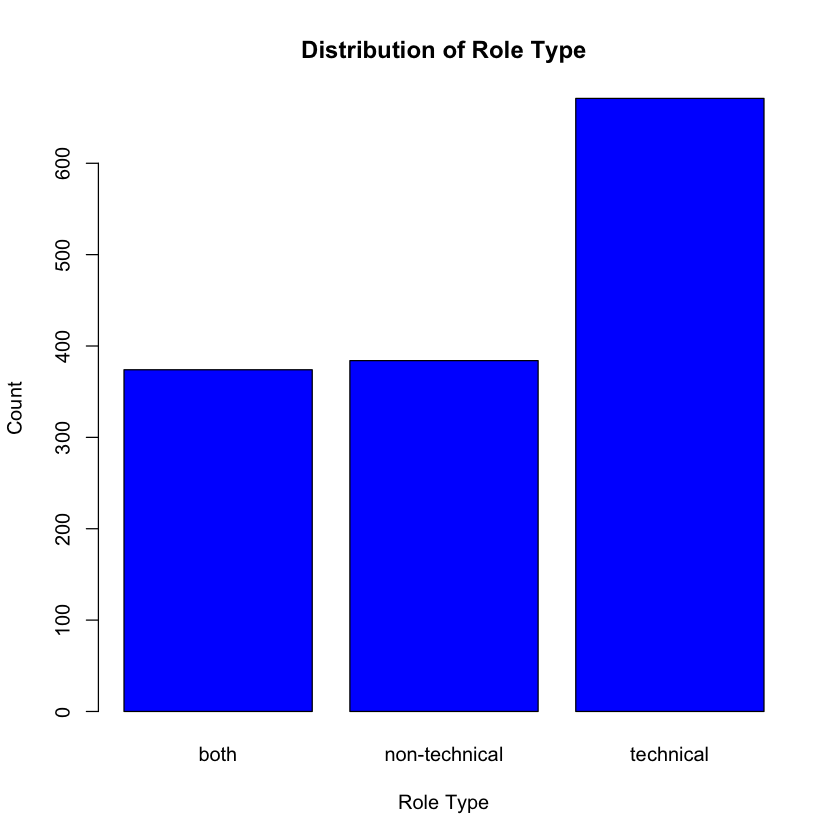

In [5]:
roleCounts = table(mainFrame$roleType)
barplot(roleCounts,main = "Distribution of Role Type",
        xlab = "Role Type",ylab = "Count",col = "Blue")

_Figure 1: Distribution of role type variable._

We see that many individuals identify as solely technical individuals. However, there are as many individuals taking on non-technical and hybrid roles as there are technical individuals. This suggest that our dataset is a reasonable mix of worker types from across the industry.

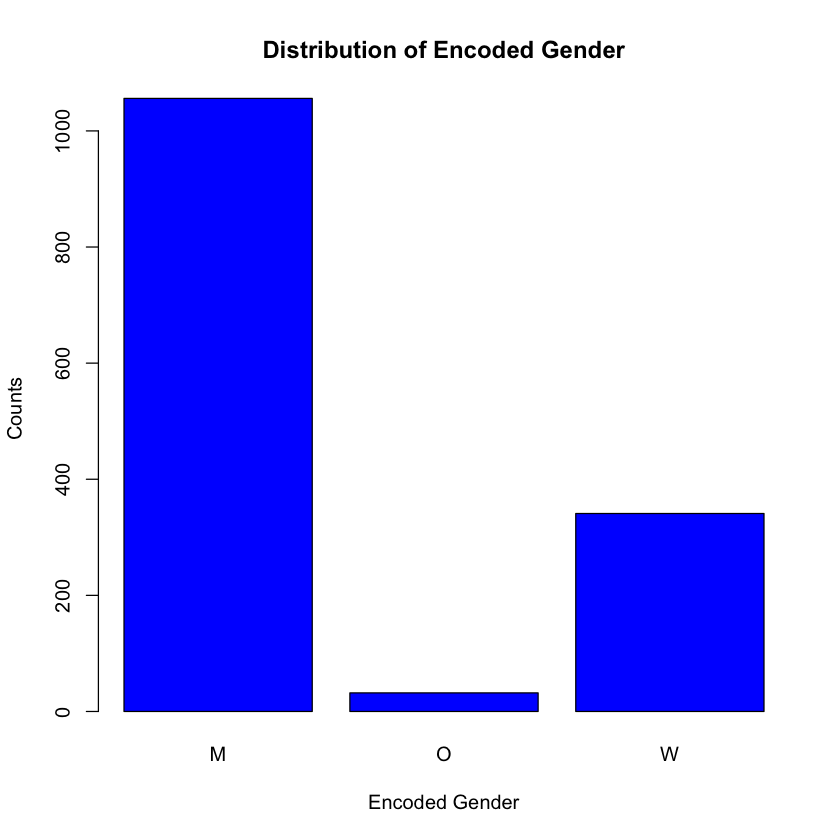

In [6]:
genderCounts = table(mainFrame$gender)
barplot(genderCounts,main = "Distribution of Encoded Gender",
        xlab = "Encoded Gender",ylab = "Counts",col = "Blue")

_Figure 2: Distribution of encoded gender._

We see that most individuals identify as men in our datset, although there is a sizable number of individuals who identify as women and a small group of individuals who identify as being non-binary. For the sake of respecting the representation of non-binary individuals in this survey, I think it is important to keep this "Other" category to ensure that they are indicated in this group.

### Search for interaction effects

It may be relevant for us to find some interaction effects within the data before we go into initial modeling steps. Let's first see if there is an interaction between gender and age.

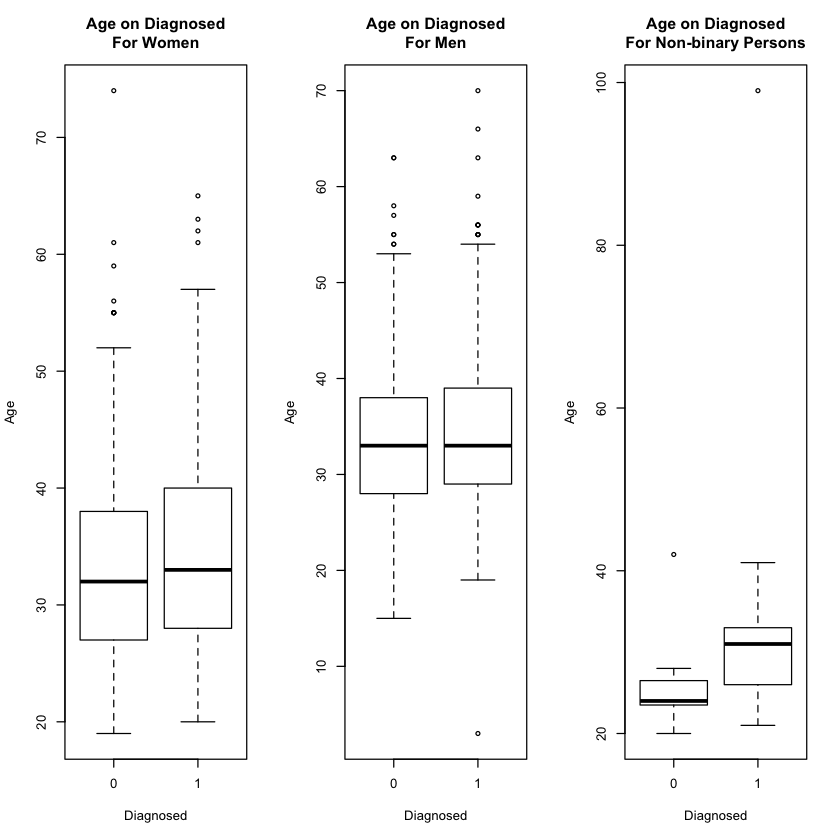

In [8]:
#get gender-leveled frames
femaleFrame = mainFrame[which(mainFrame$gender == "W"),]
maleFrame = mainFrame[which(mainFrame$gender == "M"),]
otherFrame = mainFrame[which(mainFrame$gender == "O"),]
#then plot each boxplot
par(mfrow = c(1,3))
boxplot(age~diagnosedWithMHD,data = femaleFrame,xlab = "Diagnosed",
        ylab = "Age",main = "Age on Diagnosed\nFor Women")
boxplot(age~diagnosedWithMHD,data = maleFrame,xlab = "Diagnosed",
        ylab = "Age",main = "Age on Diagnosed\nFor Men")
boxplot(age~diagnosedWithMHD,data = otherFrame,xlab = "Diagnosed",
        ylab = "Age",main = "Age on Diagnosed\nFor Non-binary Persons")

_Figure 3: Age on Diagnosed conditioned by gender of the individual._

As we can tell, age does not seem to be having a severe interaction with men and women age ranges, but it seems as though it is making a slight predictive difference when we condition on individuals of other genders. This is a very small subset of the dataset, which suggests that we might not need to consider it for initial modeling. That being said, this interaction will likely be very relevant for when we are considering interactions in the model selection phase.

In [9]:
#make isUSA variable
mainFrame$isUSA = 0
mainFrame[which(mainFrame$workCountry == "United States of America"),
          "isUSA"] = 1
#then make level vectors
genderLevs = c("W","M","O")
usaLevs = c(0,1)
interactionMat = matrix(0,nrow = length(usaLevs),ncol = length(genderLevs))
#fill with proportion diagnosed in these sections
for (i in 1:length(genderLevs)){
    for (j in 1:length(usaLevs)){
        #get considered level
        genderLev = genderLevs[i]
        usaLev = usaLevs[j]
        #get subseted frame
        subFrame = mainFrame[which(mainFrame$gender == genderLev &
                                   mainFrame$isUSA == usaLev),]
        #get proportion
        propDiagnosed = sum(subFrame$diagnosedWithMHD) / dim(subFrame)[1]
        #then store it
        interactionMat[j,i] = propDiagnosed
    }
}
#name parts
rownames(interactionMat) = usaLevs
colnames(interactionMat) = genderLevs
interactionMat

,W,M,O
0,0.5842697,0.3702929,0.7142857
1,0.6706349,0.5017301,0.8333333


_Table 1: Proportion diagnosed given whether the respondent works in the USA (rows) and the gender of the respondent (columns)._

We see that there is some slight interaction effects, as those of other genders in the USA seem to have a high rate of mental health diagnosis but those who are men and work outside of the USA seem to have very low rates of mental health diagnosis. This suggests that there is a meaningful interaction between these two features that shouldn't be ignored in our initial modeling stage.

In [10]:
#have a function for making an interaction effect
makeInteractionMat <- function(rowVar,colVar){
    #helper for making the interaction matrix for other relevant variables
    rowLevs = unique(mainFrame[,rowVar])
    colLevs = unique(mainFrame[,colVar])
    interactionMat = matrix(0,nrow = length(rowLevs),ncol = length(colLevs))
    #fill with proportion diagnosed in these sections
    for (i in 1:length(rowLevs)){
        for (j in 1:length(colLevs)){
            #get considered level
            rowLev = rowLevs[i]
            colLev = colLevs[j]
            #get subseted frame
            subFrame = mainFrame[which(mainFrame[,rowVar] == rowLev &
                                   mainFrame[,colVar] == colLev),]
            #get proportion
            propDiagnosed = sum(subFrame$diagnosedWithMHD) / dim(subFrame)[1]
            #then store it
            interactionMat[i,j] = propDiagnosed
        }
    }
    #name parts
    rownames(interactionMat) = rowLevs
    colnames(interactionMat) = colLevs
    return(interactionMat)
}

In [11]:
genderRoleInteractionMat = makeInteractionMat("roleType","gender")
genderRoleInteractionMat

,M,W,O
technical,0.4411765,0.6530612,0.6428571
non-technical,0.4680000,0.6015625,0.8333333
both,0.4222973,0.7272727,0.9166667


_Table 2: Proportion Diagnosed on role type (rows) and gender of the respondent (columns)._

We see that there are some slight interaction effects occuring here, as it seems like individuals who take on both technical and non-technical positions who identify as women or other genders tend to have high rates of mental health diagnosis. This may suggest that individuals of underpriveleged backgrounds in technology who are taking on many roles tend to face a level of stress and anxiety that leads to a form of mental health diagnosis.

In [12]:
roleCompanyInteractionMat = makeInteractionMat("roleType","companySize")
roleCompanyInteractionMat

,26-100,6-25,Self-Employed,More than 1000,100-500,500-1000,1-5
technical,0.5112360,0.4416667,0.5428571,0.4862385,0.5238095,0.4000000,0.4545455
non-technical,0.5200000,0.5121951,0.5053763,0.5955056,0.5074627,0.5000000,0.2142857
both,0.4126984,0.4081633,0.5161290,0.5964912,0.4528302,0.4666667,0.6923077


_Table 3: Proportion Diagnosed on role type (rows) and company size of the respondent (columns)._

It is difficult to point out a clear interaction effect in this context: Perhaps it might be easier to consider this interaction at a later step.

In [13]:
roleCountryInteractionMat = makeInteractionMat("isUSA","roleType")
roleCountryInteractionMat

,technical,non-technical,both
0,0.4086022,0.4459459,0.3831169
1,0.5510204,0.5635593,0.5681818


_Table 4: Proportion diagnosed on whether the work is in the united state (rows) and the role type of the respondent._

Unfortunately, we see very little interaction between these two variables.

# Initial Modeling

## Decision Tree

As discussed in the conclusion of our [exploratory data analysis](exploratoryDataAnalysis.ipynb), it is apparent that we could likely pick up on more indirect and interaction effects in our data if we consider using a decision tree. This gives us a strong graphical representation of the predictive effects presented by our data.

We will start by using all variables except for our state and country variable and we will also include a variable for representing when work is in the USA. We will call this variable ```isUSA```.

In [14]:
initialMod.tree = tree(diagnosedWithMHD ~ age + roleType + factor(isUSA) 
                        + gender + companySize,data = mainFrame,
                       split = "deviance")

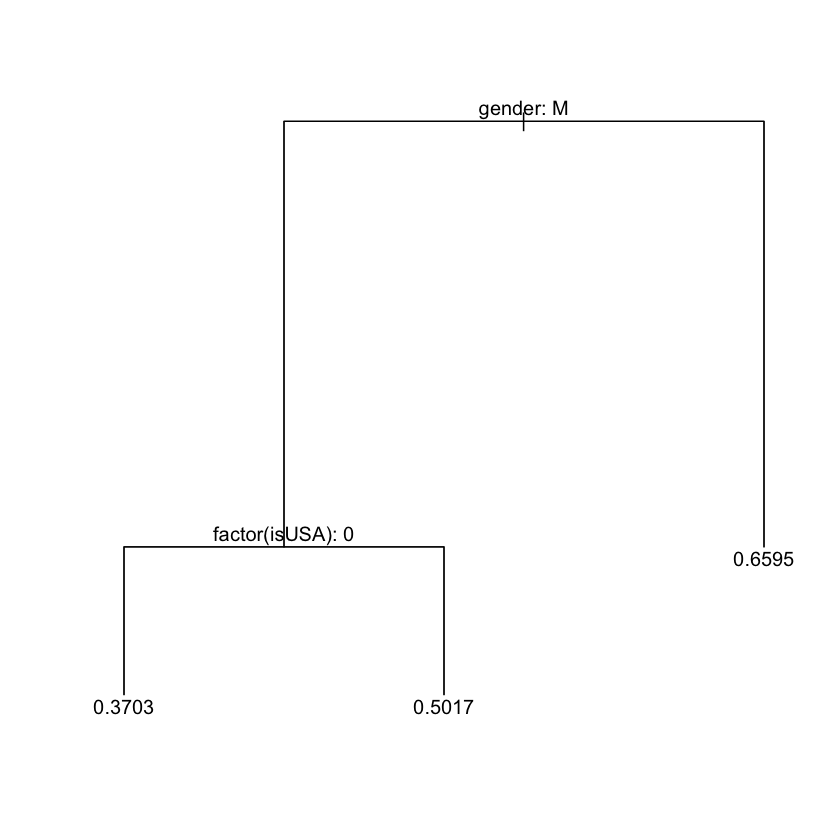

In [15]:
#then plot
plot(initialMod.tree)
text(initialMod.tree,pretty = 0)

_Figure 4: Our initial decision tree._

As expected, gender plays an essential role in informing the diagnosis rate. In particular, the effect suggests that those who identify as men are more likely to not have a mental health diagnosis than those who identify as other genders. We do see that whether or not the work is in the USA plays an essential role in dictating the $.5$ divide used to classify our observations.

In [16]:
#check predictive accuracy
mainFrame$predictions = ifelse(predict(initialMod.tree) > .5,1,0)
correctFrame = mainFrame[which(
                        mainFrame$diagnosedWithMHD == mainFrame$predictions),]
propAccurate = dim(correctFrame)[1] / dim(mainFrame)[1]
#then get percent
print(paste("The proportion accurate is",signif(propAccurate,sigLev)))

[1] "The proportion accurate is 0.586"


We see that we are only getting about $58.6\%$ of our predictions right. This is so far a pretty bad model, but nonetheless a model that we might have to work with. I'm under the impression that we will have a better time diagnosing our feature engineering woes if we study the parameters of a logistic regression model.

## Logistic Regression

We will use the same variables as before, but we will now make the roleType-gender interaction explicit and make the isUSA-gender interaction explicit.

In [17]:
initialMod.logr = glm(diagnosedWithMHD ~ age + factor(roleType)*factor(gender)
                + factor(isUSA)*factor(gender) + factor(companySize),
                      data = mainFrame,family = "binomial")

### Diagnostics

In [18]:
#check predictive accuracy
mainFrame$predictions = predict(initialMod.logr,type = "response")
mainFrame$predictions = ifelse(mainFrame$predictions > 0.5,1,0)
correctFrame = mainFrame[which(
                        mainFrame$diagnosedWithMHD == mainFrame$predictions),]
propAccurate = dim(correctFrame)[1] / dim(mainFrame)[1]
#then get percent
print(paste("The proportion accurate is",signif(propAccurate,sigLev)))

[1] "The proportion accurate is 0.609"


We are only doing slightly better with the logistic regression model. Let us see if we can figure out which events are hard to predict using a confusion matrix.

In [19]:
confusionMat = matrix(0,nrow = 2,ncol = 2)
for (i in 1:2){
    for (j in 1:2){
        #get level associated
        confusionMat[i,j] = length(which(mainFrame$predictions == i - 1 &
                                         mainFrame$diagnosedWithMHD == j - 1))
    }
}
#name columns
rownames(confusionMat) = c("Predict 0","Predict 1")
colnames(confusionMat) = c("Actual 0","Actual 1")
confusionMat

,Actual 0,Actual 1
Predict 0,463,306
Predict 1,253,407


_Table 5: Our confusion matrix for our initial logistic regression._

It looks like our false positive and false negative rate is about the same in both contexts. This suggests that what we aren't really dealing with is an imbalanced classes problem, but rather a fundamental set of errors in our model. Let us take a look at our residuals for this plot.

In [20]:
brierScore = mean(residuals(initialMod.logr,type = "response")^2)
print(paste("We have a brier score of",signif(brierScore,sigLev)))

[1] "We have a brier score of 0.234"


On average, our predictions are off the actual outcome by around $\sqrt{.234} \cdot 100\% \approx 48.4\%$. This is not very ideal for predictive purposes, but we will nonetheless have to work with it for our difficult prediction problem.

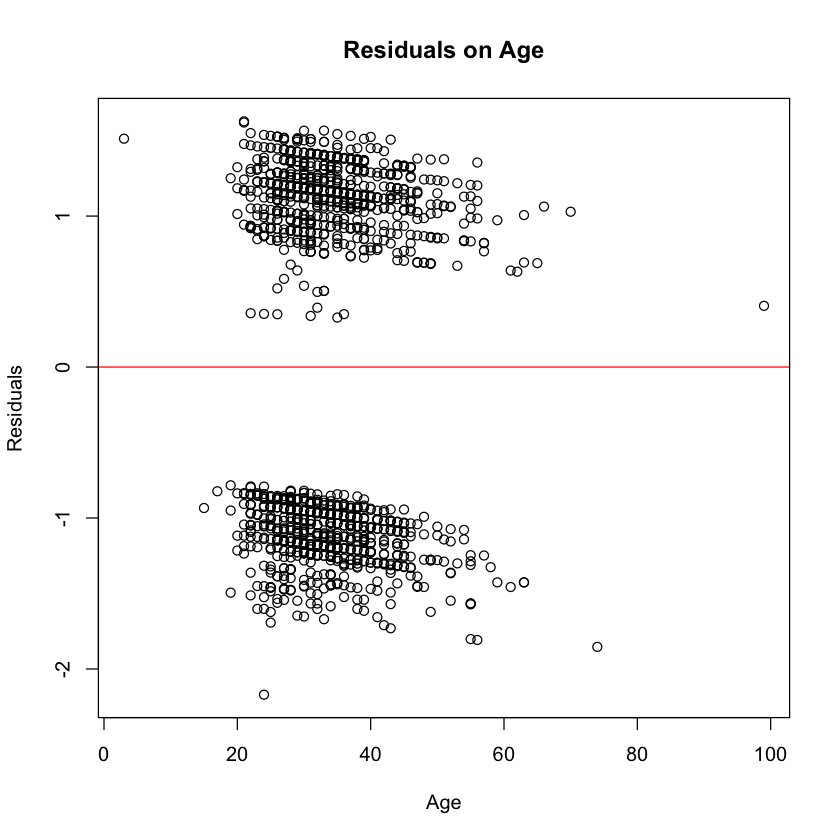

In [21]:
#plot residuals on age
resids = residuals(initialMod.logr)
plot(mainFrame$age,resids,xlab = "Age",ylab = "Residuals",
     main = "Residuals on Age")
abline(0,0,col = "red")

_Figure 5: Response Residuals on Age._

We see that we have a slight nonlinearity, as the tunnel moves down the older our ages get. That being said, this nonlinearity is so slight that I don't think it should be a priority for our analysis.

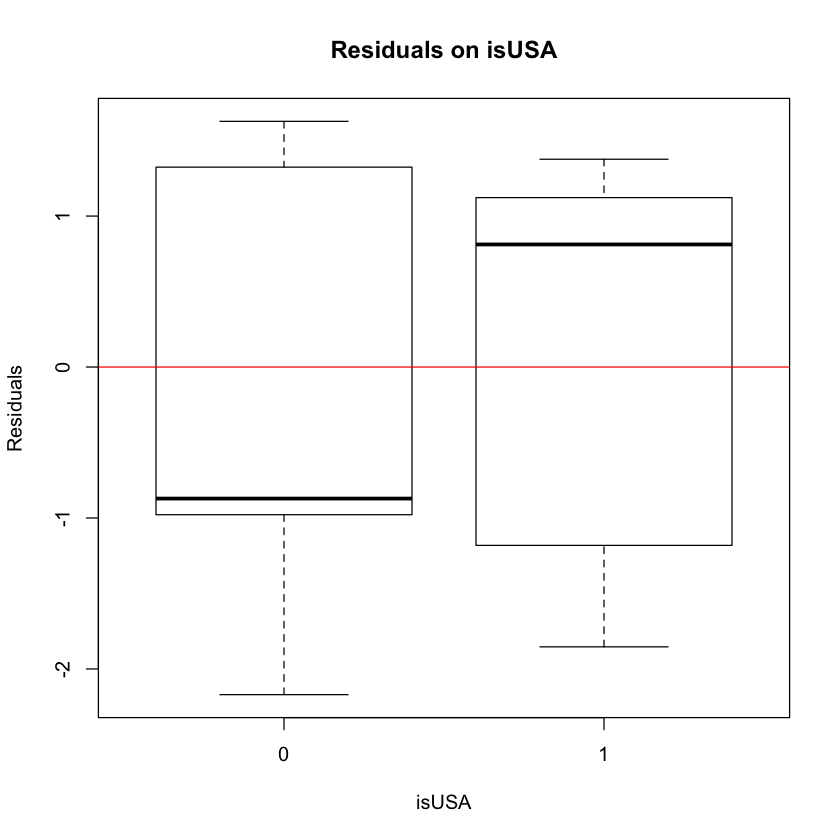

In [22]:
#plot our residuals on isUSA
boxplot(resids ~ mainFrame$isUSA,xlab = "isUSA",ylab = "Residuals",
        main = "Residuals on isUSA")
abline(0,0,col = "red")

_Figure 6: Residuals on isUSA._

We see that while the boxes are quite similar, it is very possible that there is some nonlinearity due to the fact that the medians of the two boxplots look to be on opposite sides of the ideal residual line.

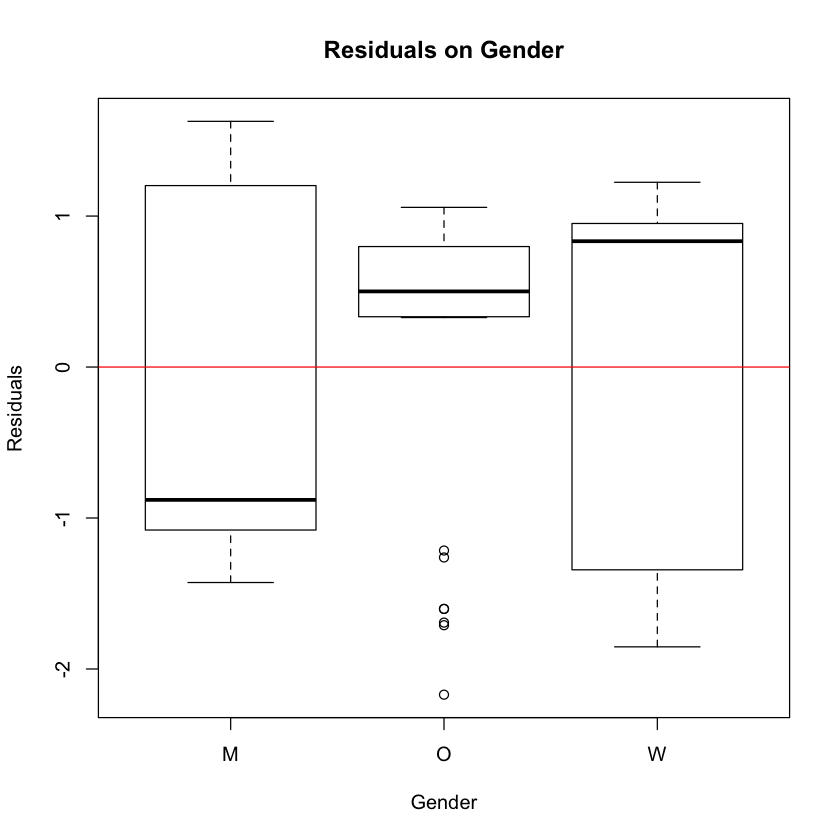

In [23]:
boxplot(resids ~ mainFrame$gender,xlab = "Gender",ylab = "Residuals",
        main = "Residuals on Gender")
abline(0,0,col = "red")

_Figure 7: Residuals on Gender._

We see very obvious break of linearity when we compare the residuals of persons who identify as women and men to residuals of persons who do not identify on the binary. That being said, this may be a biased visualization due to the fact that there are way fewer individuals who identify as other in this dataset than those who identify as female and male (see Figure 2).

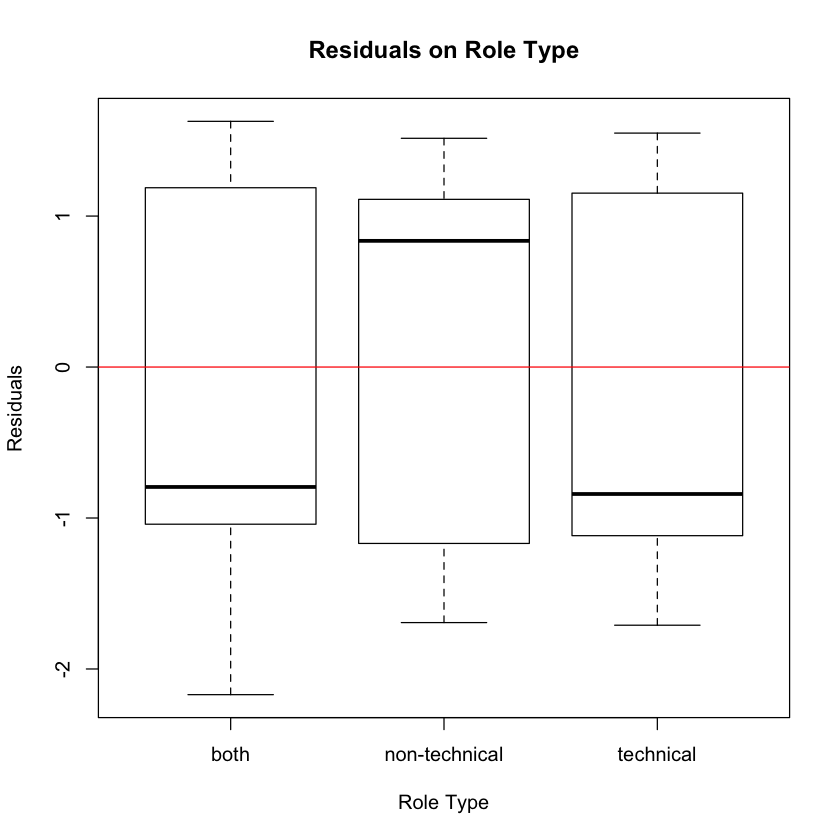

In [24]:
boxplot(resids ~ mainFrame$roleType,xlab = "Role Type",ylab = "Residuals",
        main = "Residuals on Role Type")
abline(0,0,col = "red")

_Figure 8: Residuals on Role Type._

Despite the slight median shift, it looks like there isn't significant non-linearity in this context._

Waiting for profiling to be done...


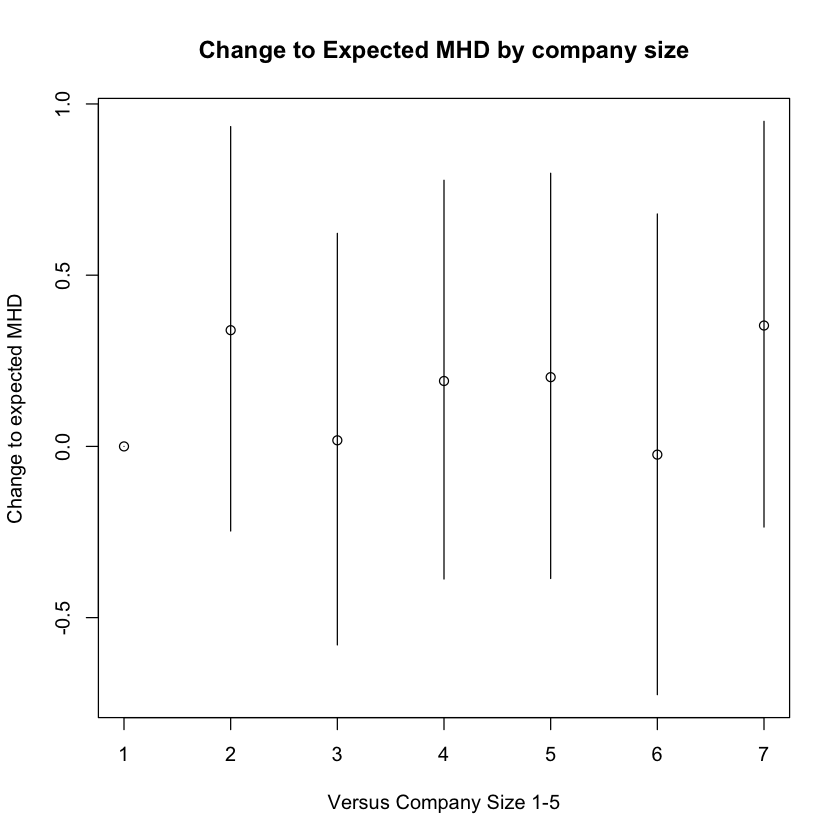

In [25]:
#contrasts for company size
#idea comes from solutions-08.Rmd, 36-401 Modern Regression
cSizeNames = c("factor(companySize)Self-Employed","factor(companySize)6-25",
               "factor(companySize)26-100","factor(companySize)100-500",
               "factor(companySize)500-1000",
               "factor(companySize)More than 1000")
companySizeContrasts = coefficients(initialMod.logr)[cSizeNames]
#include baseline
companySizeContrasts = c(0,companySizeContrasts)
companySizeCIs = confint(initialMod.logr, parm=cSizeNames)
#include baseline
companySizeCIs = rbind(c(0,0),companySizeCIs)
#on daily usage
plot(1:(length(cSizeNames) + 1),companySizeContrasts,
     xlab="Versus Company Size 1-5",
     ylab="Change to expected MHD", ylim=c(min(companySizeCIs),
                                             max(companySizeCIs)),
     main="Change to Expected MHD by company size")
segments(x0=1:(length(cSizeNames) + 1), y0=companySizeCIs[,1],
         x1=1:(length(cSizeNames) + 1), y1=companySizeCIs[,2])

_Figure 9: Change to expected link value versus company size._

It is apparent that none of these levels are really making large changes to the link response. In particular, none are really changing from the baseline. It may be useful to start considering the option of removing the company size variable completely from the regression.

# Model Selection

We will perform the following steps to perform our model selection procedure:

* We will first split our dataset in half, where one half will become our test set. the other half (our selection set) will be split further into a 20-80 split, where $80\%$ of this half will become our training set and $20\%$ of this set will become our validation set.

In [64]:
#do test-selection split
numObs = dim(mainFrame)[1]
testRows = sample(1:numObs,round(numObs / 2))

In [65]:
testFrame = mainFrame[testRows,]
selectionFrame = mainFrame[-testRows,]
write.csv(testFrame,"../data/processed/test.csv",row.names = FALSE)

In [66]:
#do train-validation split
numSelectionObs = dim(selectionFrame)[1]
trainProp = .8
#reset rownames
rownames(selectionFrame) = NULL
#then get training rows
trainRows = sample(1:numSelectionObs,
                   round(numSelectionObs * trainProp))

In [67]:
trainFrame = selectionFrame[trainRows,]
valFrame = selectionFrame[-trainRows,]
write.csv(trainFrame,"../data/processed/train.csv",row.names = FALSE)
write.csv(valFrame,"../data/processed/validation.csv",row.names = FALSE)

In [68]:
#load in older datasets
trainFrame = read.csv("../data/processed/train.csv")
valFrame = read.csv("../data/processed/validation.csv")

* We will then fit both our decision tree and logistic regression models using the train frame, and then select our model using fit on the validation set.

* Prior to selecting the model on the validation set, we will select our variables for our logistic regression using a leave-one-out (LOOCV) cross-validation method on the training set accross a variety of different models. In particular, we will consider reintroducing the interaction between age and gender and role type and company size, consider removing the interactions between gender and isUSA and between gender and role type, and we will consider removing the companySize variable from use.

In [69]:
#build out all possible models to consider
#idea came from solutions-08.Rmd
#helper script for creating all of our new model formulae
formulaeVec = vector(length = 0,mode="character")
#hardcoded default initialMod.lm
initialTerms = c("age","factor(gender)","factor(roleType)","factor(isUSA)",
                 "factor(companySize)","factor(gender):factor(roleType)",
                 "factor(gender):factor(isUSA)")
counter = 0 #to keep track of options
#loop through choices
for (ageGenderInt in c(TRUE,FALSE)){
    for (roleSizeInt in c(TRUE,FALSE)){
        for (genderRoleInt in c(TRUE,FALSE)){
            for (genderUSInt in c(TRUE,FALSE)){
                for (incCompanySize in c(TRUE,FALSE)){
                    givenTerms = initialTerms
                    if (ageGenderInt){
                        #include the interaction
                        givenTerms = union(givenTerms,
                                           "age:factor(gender)")
                    }
                    if (incCompanySize){
                        #consider company size variables
                        if (roleSizeInt){
                            givenTerms = union(givenTerms,
                                    "factor(roleType):factor(companySize)")
                        }
                    }
                    if (!genderRoleInt){ #remove
                        givenTerms = setdiff(givenTerms,
                                    "factor(gender):factor(roleType)")
                    }
                    if (!genderUSInt){
                        givenTerms = setdiff(givenTerms,
                                    "factor(gender):factor(isUSA)")
                    }
                    if (!incCompanySize){ #remove it
                        givenTerms = setdiff(givenTerms,"factor(companySize)")
                    }
                    #then make new formula
                    newForm = paste("diagnosedWithMHD ~",
                                 paste(givenTerms,collapse="+"))
                    formulaeVec = union(formulaeVec,newForm)
                }
            }
        }
    }
}

In [70]:
#quick helper for getting brier score
brierScore <- function(givenMod,predictFrame){
    #quick helper for calculating the brier score of a given model
    predictions = predict(givenMod,newdata = predictFrame,type = "response")
    bScore = mean((predictFrame$diagnosedWithMHD - predictions)^2)
    return(bScore)
}
#helper for running cross validation
crossVal <- function(givenForm,givenFrame,numFolds = 5){
    #helper for running cross validation
    scoreVec = rep(0,numFolds)
    #run through fold options
    for (i in 1:numFolds){
        #get test and train folds
        testFold = givenFrame[which(givenFrame$fold == i),]
        trainFold = givenFrame[which(givenFrame$fold != i),]
        #fit our model using the train fold
        newMod.logr = glm(givenForm,trainFold,family = "binomial")
        #get brier score
        scoreVec[i] = brierScore(newMod.logr,testFold)
    }
    #then return mean of score vector
    return(mean(scoreVec))
}

In [71]:
#make fold assignment on trainframe
trainFrame$fold = sample(1:5,size = dim(trainFrame)[1],replace = TRUE)

In [72]:
#then run through proces
cvVec = lapply(formulaeVec,crossVal,givenFrame = trainFrame)

In [73]:
optIndex = which.min(cvVec)
bestFormula <- formulaeVec[optIndex]
secondOptIndex = which.min(cvVec[-optIndex])
secondBestFormula = formulaeVec[-optIndex][secondOptIndex]
print(paste("The best formula is",bestFormula))
print(paste("The second-best formula is",secondBestFormula))

[1] "The best formula is diagnosedWithMHD ~ age+factor(gender)+factor(roleType)+factor(isUSA)+age:factor(gender)"
[1] "The second-best formula is diagnosedWithMHD ~ age+factor(gender)+factor(roleType)+factor(isUSA)"


As we can see, our best formula by our cross-validation method removes our company size variable and includes the interaction between age and gender. The second best formula is also quite close, removing the interaction between gender and age. Since the second-best formula seems to remove an interaction between two variables that I believe to be very important for predicting diagnosis, I think it might be useful to consider both of these models in our model selection step.

In [74]:
bestLRMod.logr = glm(bestFormula,data = trainFrame,family = "binomial")
secondBestLRMod.logr = glm(secondBestFormula,data = trainFrame,
                           family = "binomial")

Let us now fit our decision tree on our training data.

In [75]:
treeMod.tree = tree(diagnosedWithMHD ~ age + factor(gender)
                       + factor(roleType) + factor(isUSA) + factor(companySize),
                    data = trainFrame)

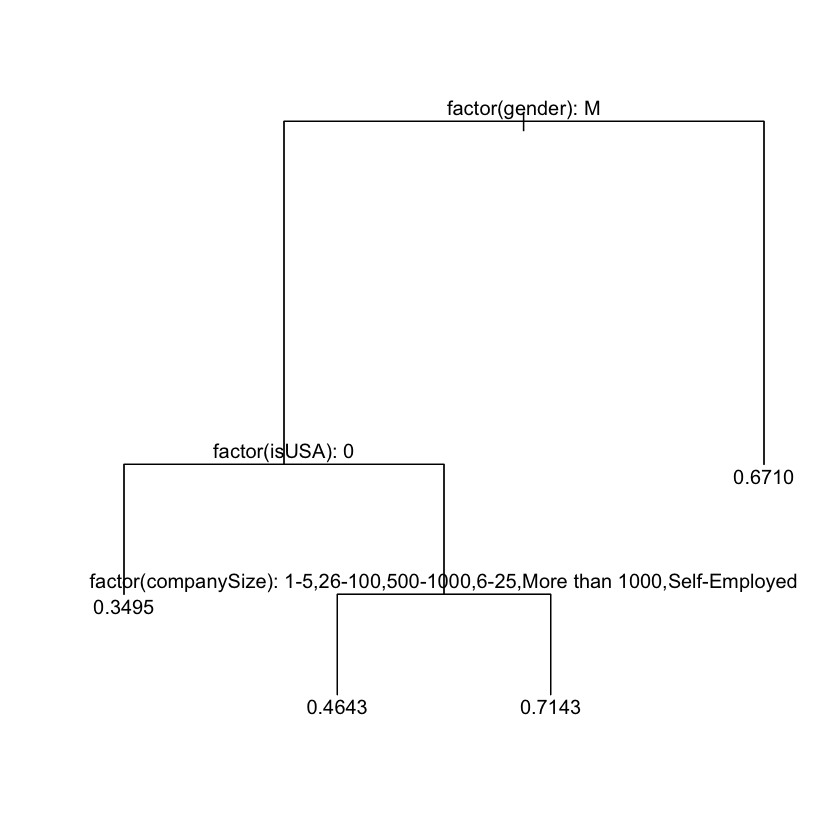

In [76]:
#then plot
plot(treeMod.tree)
text(treeMod.tree,pretty = 0)

_Figure 10: Decision tree fitted to our training dataset._

We see that now our model seems to be also including age as a relevant variable.

Let us see how well these models perform on the validation set using the Brier Score benchmark.

In [80]:
#get their brier scores
bestLRModBS = brierScore(bestLRMod.logr,valFrame)
secondBestLRModBS = brierScore(secondBestLRMod.logr,valFrame)
#calculate brier score of the decision tree
decTreePredictions = predict(treeMod.tree,newdata = valFrame)
decTreeBS = mean((valFrame$diagnosedWithMHD - decTreePredictions)^2)
#print out information
brierScoreFrame = data.frame(modelName = c("Best Logistic Regression",
                                           "Second-Best Logistic Regression",
                                           "Decision Tree"),
                             brierScore = c(bestLRModBS,secondBestLRModBS,
                                            decTreeBS))
brierScoreFrame$brierScore = signif(brierScoreFrame$brierScore,sigLev + 1)
brierScoreFrame

modelName,brierScore
Best Logistic Regression,0.2226
Second-Best Logistic Regression,0.2274
Decision Tree,0.2335


_Table 6: Models by performance on predicting the validation set._

We see that our best logistic regression has the best brier score for predicting the data out-of-sample. Thus, we will choose this model.

In [78]:
#get formula
finalModelFormula = bestFormula
#then export information
if (!dir.exists("../models")){
    dir.create("../models")
}
write(finalModelFormula,"../models/finalLogisticRegressionFormula.txt")